# Analyzing NYC High School DATA

# Project Introduction 

In this project, we will expore variouos data sets which range from 2011 to 2012 to understand if there are any patterns or factors effecting SAT scores. I will focus on finding which factors drive difference in SAT score.

# Methodology
Descriptive statistics(eg,r-value,mean) and data visulations will be used in this project.

I will focus on cleaning data,combining 7 data sets into one data set at the begining. Then I will focuse on analysing correlation between safety scoroe factor,race factor,gender factor and SAT score. 

Data set will be used:

1,https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4 - SAT scores for each high school in New York City
2,https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt- Attendance information for each school in New York City
3,https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3 - Information on class size for each school
4,https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
5,https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a - The percentage of students who graduated, and other outcome information
6,https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j - Demographic information for each school
7,https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8 - Surveys of parents, teachers, and students at each school

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
#Put all csv data in to one file
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
#Create a data disctionary like  {'ap_2010':'schools/ap_2010.csv'}
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    key_name=f.replace(".csv", "")
    data[key_name] = d

# Read in the surveys

In [2]:
#Servey data sets are not in csv format, we need to conbined them 
#and read them seperatly.
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

#Change column name upper case
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
#Put servey data set in to data
data["survey"] = survey

# Add DBN columns

In [3]:
#When we explored all of the data sets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column,
#though, so we can create DBN.
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    #put 2 zeros in front of string_repersentaion 
    else:
        return "0"+ string_representation 
    
#Create a new column called padded_csd in the class_size data set.
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
#Combined padded_csd and class size to create DBN
data["class_size"]["DBN"] = data["class_size"]["padded_csd"]+data["class_size"]["SCHOOL CODE"]

In [4]:
data['class_size']['DBN']

0        01M015
1        01M015
2        01M015
3        01M015
4        01M015
5        01M015
6        01M015
7        01M015
8        01M015
9        01M015
10       01M015
11       01M015
12       01M019
13       01M019
14       01M019
15       01M019
16       01M019
17       01M019
18       01M019
19       01M019
20       01M019
21       01M019
22       01M019
23       01M019
24       01M019
25       01M020
26       01M020
27       01M020
28       01M020
29       01M020
          ...  
27581    32K556
27582    32K556
27583    32K556
27584    32K556
27585    32K556
27586    32K556
27587    32K556
27588    32K556
27589    32K556
27590    32K556
27591    32K556
27592    32K556
27593    32K556
27594    32K556
27595    32K564
27596    32K564
27597    32K564
27598    32K564
27599    32K564
27600    32K564
27601    32K564
27602    32K564
27603    32K564
27604    32K564
27605    32K564
27606    32K564
27607    32K564
27608    32K564
27609    32K564
27610    32K564
Name: DBN, Length: 27611

# Convert columns to numeric

In [5]:
#Change 3 columns into numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#Create new column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#Find lat and lon by function and create columns called "lat" and "lon"
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

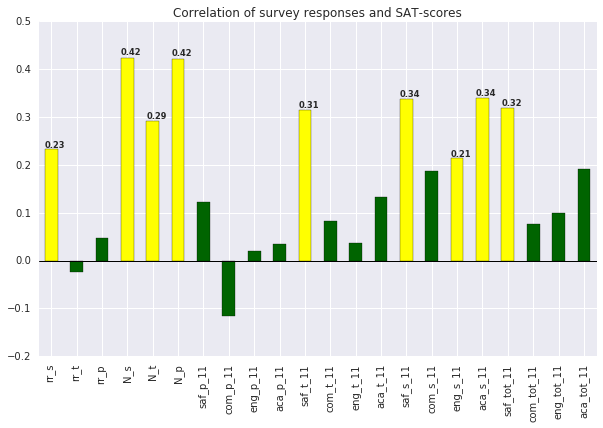

In [12]:
# There are several fields in combined that originally came from a survey of parents, teachers, and students.
# Make a bar plot of the correlations between these fields and sat_score.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10, 6))
colors=['yellow' if (x>0.2) else 'darkgreen' for x in combined.corr()['sat_score'][survey_fields]]
ax=combined.corr()["sat_score"][survey_fields].plot.bar(color=colors,title="Correlation of survey responses and SAT-scores")
for p in ax.patches:
    if p.get_height()>0.20:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x(), p.get_height()*1.02),fontsize="small", fontweight="demibold")
ax.axhline(y=0.0,color='black',linestyle='-',linewidth=1)


According to the above chart, yellow bars mean that r-value is higher than 0.2. We will focus on looking at those factors. There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

rr_s, the student rsponse rate, is higher than rr_t, the teachers response rate,correlates with sat_score, which makes sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

You may have noticed that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. In addistion to N_s,N_t,N_p, saf_t_11 and saf_s_11 has hight r-value,which make senseas as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

I will dig into safety and sat score to figure out which schools have low safety scores.

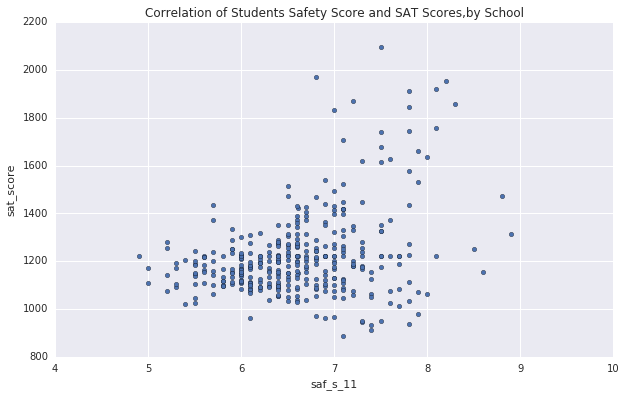

In [13]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score
ax=combined.plot.scatter(y='sat_score',x='saf_s_11',figsize=(10,6),title="Correlation of Students Safety Score and SAT Scores,by School")
sns.set_style('dark')

There appears to be a correlation between SAT scores and safety,even though it is not a strong indication. We can see a cluster between 6-7 safety score. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

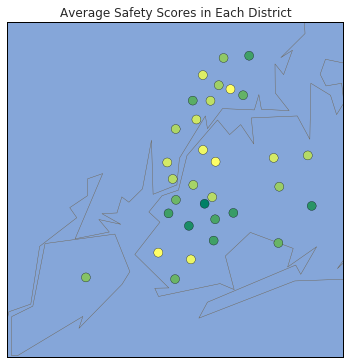

In [14]:
#Map out safety scores
from mpl_toolkits.basemap import Basemap

#Create a new dataset grouby school dist
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

#Set up a map
fig = plt.figure(figsize=(10, 6))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#Change lon and lat columns to a list
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
# Create a map 
ax=m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.title('Average Safety Scores in Each District')
plt.show()

Yellow points mean that schools have the higher average safety score, green points means the shcools have low average safety score. From the map we can tell that schools in upper mahaantan,part of Queens and Bronx have a higher safety score.

# Explore Racial differences in SAT scores

By plotting out the correlations between racial columns and sat_score, we can determine whether there are any racial differences in SAT performance.

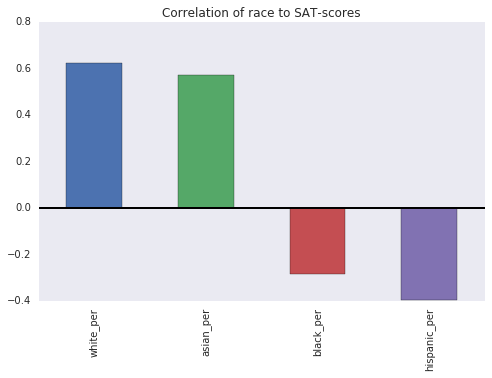

In [57]:
racial_col=["white_per", "asian_per", "black_per", "hispanic_per"]
ax=combined.corr()['sat_score'][racial_col].plot.bar(figsize=(8,5),title='Correlation of race to SAT-scores')
sns.set_style("dark")
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=2)

From the above bar chart, we can see that a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. We can explore the correlation of hispanic parent with sat_score since it has the highest negative correlation. 

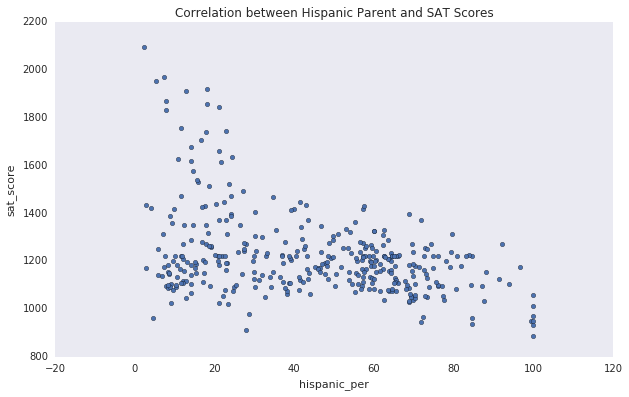

In [16]:
#Make a scatter plot of hispanic_per vs. sat_score
his_sat=combined.plot.scatter('hispanic_per','sat_score',figsize=(10,6))
plt.title('Correlation between Hispanic Parent and SAT Scores')


From the above chart, we can see the school with the higher percentage of hispanic parent has the lower sat score, which also explian that more studens learning English in the shcool, the lower SAT scores.

In [17]:
#Research any schools with a hispanic_per greater than 95%
hispanic_95=combined.loc[combined["hispanic_per"] > 95,"SCHOOL NAME"]
print(hispanic_95)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


We can google the name of those school. 
The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [18]:
#Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
combined.loc[(combined['hispanic_per']<10) & (combined['sat_score']>1800),'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

After google above schools, I find that many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

I am intereted in exploring race distribution in elite school which has 
average sat over 1800 compared to all schools


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



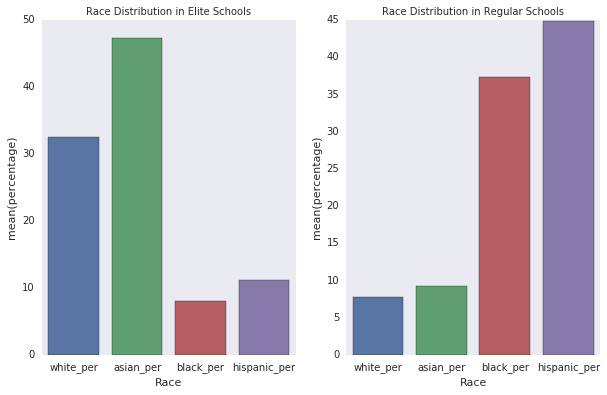

In [24]:
racial_dbn_col=["white_per", "asian_per", "black_per", "hispanic_per",'DBN']
elite_school=combined.loc[combined['sat_score']>1800,racial_dbn_col]
all_school=combined.loc[combined['sat_score']<1800,racial_dbn_col]

#Select racial columns
race=[c for c in elite_school if c.endswith('per')]
#Change multipel racial columns into one column--create a new dataset for plotting
elite_school_race=pd.melt(elite_school,id_vars='DBN',value_vars=race, value_name='percentage')
elite_school_race.rename({'variable':'Race'},axis=1,inplace=True)

fig,ax=plt.subplots(figsize=(10,6))
#creat bar graphs for elit school
ax1=plt.subplot(1,2,1)
ax1=sns.barplot(x='Race', y='percentage', data=elite_school_race,ci=None)
ax1.set_title('Race Distribution in Elite Schools',fontsize='medium')

#Do the same work on all_school dataset
race=[c for c in all_school if c.endswith('per')]
all_school_race=pd.melt(all_school,id_vars='DBN',value_vars=race,value_name='percentage')
all_school_race.rename({'variable':'Race'},axis=1,inplace=True)
ax2=plt.subplot(1,2,2)
ax2=sns.barplot(x='Race',y='percentage',data=all_school_race,ci=None)
ax2.set_title('Race Distribution in Regular Schools',fontsize='medium')

Above 2 charts further explain that schools with over 1800 sat score have less black people and hispanic people.On the contrary, schools with lower sat score have less white peopple and Asian people.

We can say that sat scroe has significant correlation with race.

# Explore Gender difference in SAT Scores

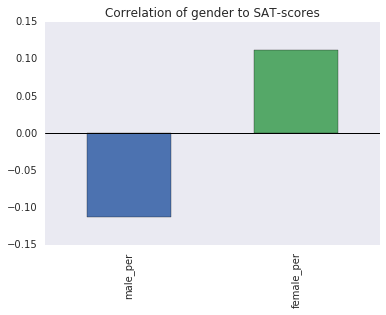

In [20]:
#We can plot out the correlations between each percentage and sat_score.
gender_col=['male_per','female_per']
ax=combined.corr()['sat_score'][gender_col].plot.bar(title='Correlation of gender to SAT-scores')
ax.axhline(y=0.0,linestyle='-',linewidth=1,color='black')


We can see that there is a positive correlation between female and SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

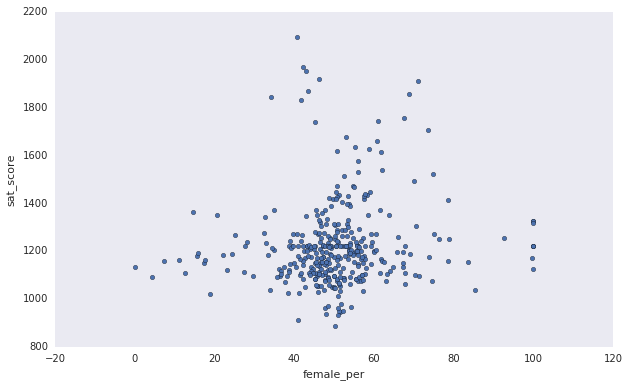

In [45]:
combined.plot.scatter('female_per','sat_score',figsize=(10,6))

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (40 to 80), and high SAT scores.

In [22]:
#Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
combined.loc[(combined['female_per']>60) & (combined['sat_score']>1700),'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

# AP Exam Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

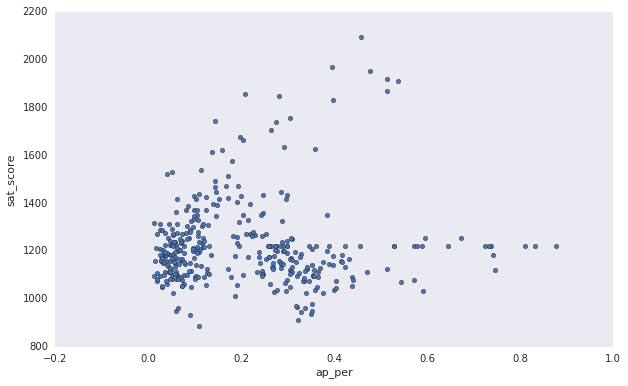

In [30]:
#Calculate the percentage of students in each school that took an AP exam.
combined['ap_per']=combined["AP Test Takers "]/combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score',figsize=(10,6))


There is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. SAT score above 1300, the the positive correlation is clear.SAT less than 1200, the correlation is not clear, but we still can see a little negative correlation.All in all, It's not an extremely strong relationship betwee Ap-test taking and SAT performance.

# Explore a correlation between class size and SAT scores

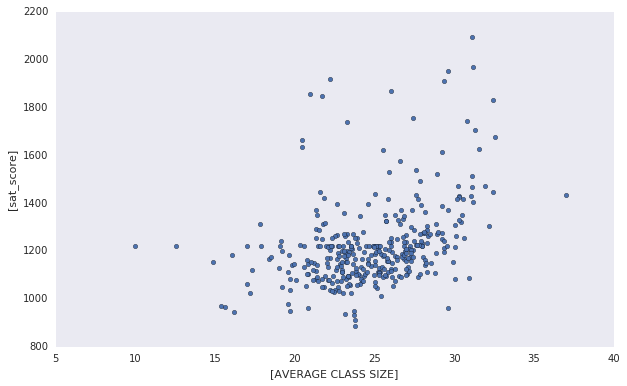

In [32]:
#Plotting scatter chart to see 
combined.plot.scatter(x=['AVERAGE CLASS SIZE'],y=['sat_score'],figsize=(10,6))

From above chart,we can the trend but it is not significnat. I will dig deeper to see the SAT Score fall in average calss szie 20-30. 

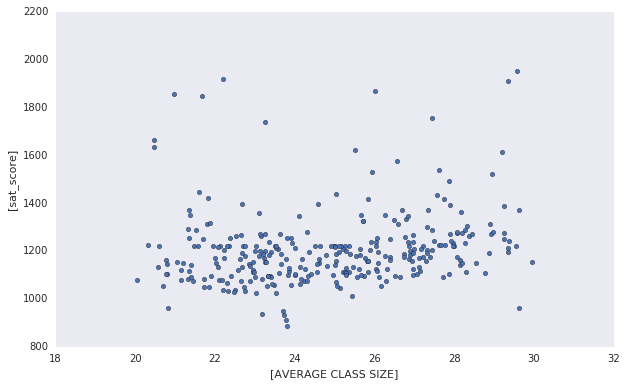

In [41]:
class_szie_2030=combined.loc[(combined['AVERAGE CLASS SIZE']>20) & (combined['AVERAGE CLASS SIZE']<30),:]
class_szie_2030.plot.scatter(x=['AVERAGE CLASS SIZE'],y=['sat_score'],figsize=(10,6))

We still can't see the strong correlation between average class size and sat score. 

# Conclusion
After conducting various analysis, I drawn below conclusions.

1, There is correlation betwee average safety score and sat_score.Looking at the safety score by district,I found  no school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.
2, There is statistic significant correlation between racial factor and SAT score. The school with less balck and hispanic students has the higher average SAT score. It could be the reason that schools with more black and hispanic students have less funding and the schools have lower saftey score. 
3,The schools focuse on science and technology have tend to have a higher SAT score. The schools with recent immigrants to the US have a lot of students who are learning English with lower SAT score. 